
# **CAP 5516 - Medical Image Computing (Spring 2025)**
Programming Assignment #2 (40 points) 

**Due: 3/10/2025, 11:59 PM (EST)**
 
#### **Deep Learning-based Brain Tumor Segmentation Using MRI**
 
**1. Dataset**
 
A subset of the data used in the 2016 and 2017 Brain Tumour Image Segmentation (BraTS) challenges [1-3] will be 
used for this programming assignment. A detailed description about the dataset can be found in [4] 
(Task01_BrainTumour). The dataset can be downloaded here: 
https://drive.google.com/drive/folders/1HqEgzS8BV2c7xYNrZdEAnrHk7osJJ--2   (Choose 
Task01_BrainTumour.tar) 
 
Once you download the dataset, there are three folders and one json file (see the figure below). “dataset.json” 
provides an overview about the dataset (e.g., MRI modality, label information for segmentation, number of training 
and testing samples, etc.). “imagesTr” is the folder for training samples. “labelsTr” is the folder for segmentation 
masks (labels) of the training samples. We do not need the “imageTs” folder (testing samples) since no ground truth 
label is provided.  
 


**2. Task** 
 
1) Data visualization  
 
Use ITK-SNAP software to visualize a few MRI samples and their corresponding segmentation masks.  
 
2) Brain tumor segmentation using U-Net 
 
Train 2D U-Net (process MRI slice by slice) or 3D U-Net (volumetric processing) for brain tumor segmentation. Do 
5-fold cross validation on the training set (“imagesTr” folder) and report the segmentation results (Dice score and 
Hausdorff Dist.) 
 
 
 
**3. What to report** 
 
1) Present a visualization example (data and segmentation mask) using the ITK-SNAP software or the code. 
2) Implementation details of the network. 
3) Use a table to list the segmentation results (Dice score and Hausdorff Dist.) for each fold, as well as the average 
results of 5-fold.  
 
You can use this code to compute Hausdorf distance:  
from medpy.metric import binary 
https://loli.github.io/medpy/_modules/medpy/metric/binary.html#hd 
 
  
 
Evaluation:  
background (label 0), necrotic and non-enhancing tumor (label 1), peritumoral edema (label 2) and GD-enhancing 
tumor (label 4). The segmentation accuracy is measured by the Dice score and the Hausdorff distance (95%) metrics 
for enhancing tumor region (ET, label 4), regions of the tumor core (TC, labels 1 and 4), and the whole tumor region 
(WT, labels 1,2 and 4). 


4) Present a few examples of your segmentation results (an example is given below) for qualitative analysis.  

  
 
**4. What to submit** 
 
(1) A report for this assignment. The quality of the report is important.  
(2) Clean code and clear instructions (e.g., a readme file) to reproduce your results. If you choose to host the code on 
GitHub, please provide the GitHub link.  
 
 
Code Examples 
 
1. TransBTS for brain tumor segmentation: https://github.com/Wenxuan-1119/TransBTS 
2. Brain tumor 3D segmentation with MONAI: https://github.com/Project-MONAI/tutorials/blob/master/3d_segmentation/brats_segmentation_3d.ipynb 
3. https://github.com/Project-MONAI/tutorials 
4. UNEt Brrain brats2020 Segmentation: https://www.kaggle.com/code/abhaybhandarkar/unet-brain-brats2020-segmentation


 
 
**References** 
 
[1] Bakas, S., Reyes, M., Int., E. & Menze, B. Identifying the Best Machine Learning Algorithms for Brain Tumor 
Segmentation, Progression Assessment, and Overall Survival Prediction in the BRATS Challenge. arXiv preprint 
arXiv:1811.02629 (2018).  
[2] Bakas, S. et al. Advancing The Cancer Genome Atlas glioma MRI collections with expert segmentation labels 
and radiomic features. Scientific Data 4, 1–13 (2017).  
[3] Menze, B. H. et al. The Multimodal Brain Tumor Image Segmentation Benchmark (BRATS). IEEE Transactions 
on Medical Imaging 34, 1993– 2024 (2015). 
[4] Simpson, Amber L., et al. "A large annotated medical image dataset for the development and evaluation of 
segmentation algorithms." arXiv preprint arXiv:1902.09063 (2019). 
 
The segmentation 
mask of your method 
for a slice.  
The ground truth 
(GT) segmentation 
mask for a slice.  


## 1. Import Packages


In [4]:
!pip install scikit-image
!pip3 install -U scikit-learn
!pip install pillow
!pip install matplotlib
!pip install pandas
!python3 -m pip install 'tensorflow[and-cuda]'

# Import necessary libraries
import os
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from skimage.transform import resize
import tensorflow.keras.backend as K
import datetime
import json
import matplotlib.pyplot as plt

# -------------------------------
# 1. Verify GPU Availability
# -------------------------------
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Available GPU devices:", tf.config.list_physical_devices('GPU'))

2025-03-10 00:42:00.885699: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-10 00:42:00.894146: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741581720.904928   30423 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741581720.907870   30423 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-10 00:42:00.919006: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Num GPUs Available:  1
Available GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 2. Get File Information

In [5]:
import numpy as np 
import pandas as pd
import os

# Get the Absolute path of this Jupyter Notebook
notebook_path = os.path.abspath("")

# Change current working directory:
os.chdir(notebook_path)


current_directory = os.getcwd()
for dirname, _, filenames in os.walk(f"{current_directory}/dataset"):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/home/malneyugnfl/Desktop/CAP_5516_Medical_Imaging_Computing/Assignments/Assignment_02/dataset/BraTS20 Training Metadata.csv
/home/malneyugnfl/Desktop/CAP_5516_Medical_Imaging_Computing/Assignments/Assignment_02/dataset/BraTS2020_training_data/content/data/volume_206_slice_110.h5
/home/malneyugnfl/Desktop/CAP_5516_Medical_Imaging_Computing/Assignments/Assignment_02/dataset/BraTS2020_training_data/content/data/volume_60_slice_48.h5
/home/malneyugnfl/Desktop/CAP_5516_Medical_Imaging_Computing/Assignments/Assignment_02/dataset/BraTS2020_training_data/content/data/volume_197_slice_68.h5
/home/malneyugnfl/Desktop/CAP_5516_Medical_Imaging_Computing/Assignments/Assignment_02/dataset/BraTS2020_training_data/content/data/volume_100_slice_40.h5
/home/malneyugnfl/Desktop/CAP_5516_Medical_Imaging_Computing/Assignments/Assignment_02/dataset/BraTS2020_training_data/content/data/volume_193_slice_132.h5
/home/malneyugnfl/Desktop/CAP_5516_Medical_Imaging_Computing/Assignments/Assignment_02/dataset/BraT

# Data Visualization using the ITK-SNAP Software

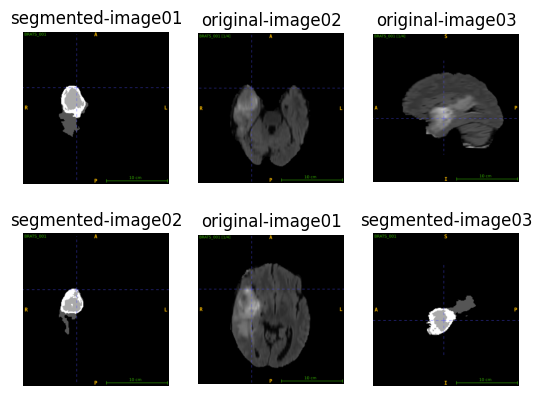

In [6]:
# Using the ITK-SNAP Software, we got a couple of images. First the original and then the segmented images

import os
import matplotlib.pyplot as plt
import PIL
%matplotlib inline

rows= 2
path = os.path.join(os.getcwd())
os.chdir(path)
files = os.listdir(f"{path}/ITK_Images")

for num,x in enumerate(files):
    img = PIL.Image.open(f"{path}/ITK_Images/{x}")
    plt.subplot(rows,3,num+1)
    plt.title(x.split('.')[0])
    plt.axis('off')
    plt.imshow(img)
    



## Define Metrics

In [7]:
def dice_coefficient(y_true, y_pred, smooth=1):
    """
    Calculates the Dice Coefficient.
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_metric(y_true, y_pred, smooth=1):
    """
    Calculates the Intersection over Union (IoU) metric.
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

In [ ]:
# Define Hausdorff Distance

from scipy.ndimage import _ni_support
from scipy.ndimage.morphology import distance_transform_edt, binary_erosion,\
    generate_binary_structure

def __surface_distances(reference, result, voxelspacing=None, connectivity=1):
    """
    The distances between the surface voxel of binary objects in result and their
    nearest partner surface voxel of a binary object in reference.
    """
    result = np.atleast_1d(result.astype(np.bool))
    reference = np.atleast_1d(reference.astype(np.bool))
    if voxelspacing is not None:
        voxelspacing = _ni_support._normalize_sequence(voxelspacing, result.ndim)
        voxelspacing = np.asarray(voxelspacing, dtype=np.float64)
        if not voxelspacing.flags.contiguous:
            voxelspacing = voxelspacing.copy()
            
    # binary structure
    footprint = generate_binary_structure(result.ndim, connectivity)
    
    # test for emptiness
    if 0 == np.count_nonzero(result): 
        raise RuntimeError('The first supplied array does not contain any binary object.')
    if 0 == np.count_nonzero(reference): 
        raise RuntimeError('The second supplied array does not contain any binary object.')    
            
    # extract only 1-pixel border line of objects
    result_border = result ^ binary_erosion(result, structure=footprint, iterations=1)
    reference_border = reference ^ binary_erosion(reference, structure=footprint, iterations=1)
    
    # compute average surface distance        
    # Note: scipys distance transform is calculated only inside the borders of the
    #       foreground objects, therefore the input has to be reversed
    dt = distance_transform_edt(~reference_border, sampling=voxelspacing)
    sds = dt[result_border]
    
    return sds

def hd(y_true, y_pred, voxelspacing=None, connectivity=1):

    result = y_pred.numpy()
    reference = y_true.numpy()


    """
    Hausdorff Distance.
    
    Computes the (symmetric) Hausdorff Distance (HD) between the binary objects in two
    images. It is defined as the maximum surface distance between the objects.
    
    Parameters
    ----------
    result : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    reference : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    voxelspacing : float or sequence of floats, optional
        The voxelspacing in a distance unit i.e. spacing of elements
        along each dimension. If a sequence, must be of length equal to
        the input rank; if a single number, this is used for all axes. If
        not specified, a grid spacing of unity is implied.
    connectivity : int
        The neighbourhood/connectivity considered when determining the surface
        of the binary objects. This value is passed to
        `scipy.ndimage.morphology.generate_binary_structure` and should usually be :math:`> 1`.
        Note that the connectivity influences the result in the case of the Hausdorff distance.
        
    Returns
    -------
    hd : float
        The symmetric Hausdorff Distance between the object(s) in ```result``` and the
        object(s) in ```reference```. The distance unit is the same as for the spacing of 
        elements along each dimension, which is usually given in mm.
        
    See also
    --------
    :func:`assd`
    :func:`asd`
    
    Notes
    -----
    This is a real metric. The binary images can therefore be supplied in any order.
    """
    hd1 = __surface_distances(result, reference, voxelspacing, connectivity).max()
    hd2 = __surface_distances(reference, result, voxelspacing, connectivity).max()
    hd = max(hd1, hd2)
    return hd


## Define U-Net Model

In [8]:
def unet_model(input_size=(128, 128, 4)):
    inputs = Input(input_size)

    # Encoding path
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoding path
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model


## Prepare the Data

In [9]:
# Prepare raw Data 

# Define the data directory (adjust this path if necessary)
# Get the Absolute path of this Jupyter Notebook
notebook_path = os.path.abspath("")

# Change current working directory:
os.chdir(notebook_path)

current_directory = os.getcwd()

data_dir = f'{current_directory}/dataset/BraTS2020_training_data/content/data'

# Get list of .h5 files
h5_files = [f for f in os.listdir(data_dir) if f.endswith('.h5')]

# Ensure that there are .h5 files in the directory
if not h5_files:
    raise FileNotFoundError(f"No .h5 files found in the directory: {data_dir}")

# Split into training and validation sets
train_files, val_files = train_test_split(h5_files, test_size=0.2, random_state=42)

print(f"Total samples: {len(h5_files)}")
print(f"Training samples: {len(train_files)}")
print(f"Validation samples: {len(val_files)}")

# Parameters
batch_size = 8  # Adjust based on GPU memory
image_dim = (128, 128)  # Adjust based on your image dimensions


Total samples: 57195
Training samples: 45756
Validation samples: 11439


## Define Data Generator

In [10]:
class DataGenerator(Sequence):
    def __init__(self, h5_files, data_dir, batch_size=16, dim=(128, 128), shuffle=True):
        self.h5_files = h5_files
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.dim = dim
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.h5_files))
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.h5_files) / self.batch_size))
        
    def __getitem__(self, index):
        # Generate indexes of the batch
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        h5_batch = [self.h5_files[k] for k in batch_indexes]
        X, y = self.__data_generation(h5_batch)
        return X, y
        
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)
        
    def __data_generation(self, h5_batch):
        # Initialize arrays
        X = np.empty((self.batch_size, *self.dim, 4), dtype='float32')  # 4 channels
        y = np.empty((self.batch_size, *self.dim, 1), dtype='float32')  # Single-channel masks
            
        for i, h5_file in enumerate(h5_batch):
            file_path = os.path.join(self.data_dir, h5_file)
            with h5py.File(file_path, 'r') as hf:
                # Check for the correct keys
                if 'image' in hf.keys() and 'mask' in hf.keys():
                    image = hf['image'][:]  # Expected shape: (H, W, 4)
                    mask = hf['mask'][:]    # Expected shape: (H, W) or (H, W, C)
                else:
                    raise KeyError(f"Unexpected keys in {h5_file}: {list(hf.keys())}")

                # If mask has multiple channels, convert to single-channel
                if mask.ndim > 2:
                    mask = np.mean(mask, axis=-1)  # Example: Convert RGB to grayscale

                # Resize images if necessary
                if image.shape[:2] != self.dim:
                    image = resize(
                        image, 
                        (*self.dim, image.shape[2]), 
                        preserve_range=True, 
                        anti_aliasing=True
                    )
                
                if mask.shape != self.dim:
                    # Use nearest-neighbor interpolation for masks to preserve labels
                    mask = resize(
                        mask, 
                        self.dim, 
                        preserve_range=True, 
                        order=0, 
                        anti_aliasing=False
                    )

                # Normalize the image
                image_max = np.max(image)
                if image_max > 0:
                    image = image.astype('float32') / image_max
                else:
                    image = image.astype('float32')

                # Normalize the mask
                mask_max = np.max(mask)
                if mask_max > 0:
                    mask = mask.astype('float32') / mask_max
                else:
                    mask = mask.astype('float32')  # All zeros

                # Assign to batch arrays
                X[i] = image  # Shape: (128, 128, 4)
                y[i] = np.expand_dims(mask, axis=-1)  # Shape: (128, 128, 1)
            
        return X, y


training_generator = DataGenerator(train_files, data_dir, batch_size=batch_size, dim=image_dim, shuffle=True)
validation_generator = DataGenerator(val_files, data_dir, batch_size=batch_size, dim=image_dim, shuffle=False)


## Compile Model

In [11]:
model = unet_model(input_size=(*image_dim, 4))  # Updated input size
model.compile(optimizer=Adam(), 
              loss='binary_crossentropy', 
              metrics=['accuracy', dice_coefficient, iou_metric])
model.summary()


I0000 00:00:1741581821.068353   30423 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14285 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      2,368 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,032,321 (118.38 MB)

 Trainable params: 31,032,321 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

## Define Logging, Checkpoints

In [12]:
# Create a timestamp for the logs
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# TensorBoard callback for visualization
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# EarlyStopping callback with multiple metric monitoring
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    verbose=1, 
    restore_best_weights=True
)

# ModelCheckpoint callback to save the best model with '.keras' extension
model_checkpoint = ModelCheckpoint(
    'model-unet.best.keras',  # Changed from '.h5' to '.keras'
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    mode='min'
)

# Combine all callbacks
callbacks = [
    early_stopping,
    model_checkpoint,
    tensorboard_callback
]


## Train the Model

In [13]:
epochs = 10  # You can adjust this based on your requirements

try:
    results = model.fit(
        training_generator,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1  # Set to 1 for progress bar, 2 for one line per epoch, 0 for silent
    )
except Exception as e:
    print(f"An error occurred during training: {e}")


/home/malneyugnfl/anaconda3/envs/deeplearning-tensorflow/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


/home/malneyugnfl/anaconda3/envs/deeplearning-tensorflow/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 4))
  warnings.warn(msg)
I0000 00:00:1741582142.832594   30658 service.cc:148] XLA service 0x7458fc013e70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741582142.832609   30658 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4090 Laptop GPU, Compute Capability 8.9
2025-03-10 00:49:02.890289: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741582143.239590   30658 cuda_dnn.cc:529] Loaded cuDNN version 90300


   3/5719 ━━━━━━━━━━━━━━━━━━━━ 4:49 51ms/step - accuracy: 0.5577 - dice_coefficient: 0.0125 - iou_metric: 0.0063 - loss: 0.6790  

I0000 00:00:1741582149.475337   30658 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5719/5719 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9926 - dice_coefficient: 0.5245 - iou_metric: 0.3903 - loss: 0.0947
Epoch 1: val_loss improved from inf to 0.01049, saving model to model-unet.best.keras
5719/5719 ━━━━━━━━━━━━━━━━━━━━ 464s 80ms/step - accuracy: 0.9926 - dice_coefficient: 0.5245 - iou_metric: 0.3903 - loss: 0.0947 - val_accuracy: 0.9964 - val_dice_coefficient: 0.6579 - val_iou_metric: 0.5118 - val_loss: 0.0105
Epoch 2/10
3492/5719 ━━━━━━━━━━━━━━━━━━━━ 2:20 63ms/step - accuracy: 0.9966 - dice_coefficient: 0.7251 - iou_metric: 0.5900 - loss: 0.0093

KeyboardInterrupt: 

## Save the Data and Logs

In [ ]:
# Save Checkpoint
model.save('final_model_unet.keras')
print("Model training complete and saved as 'final_model_unet.keras'.")


# Save the training history to a JSON file
with open('training_history.json', 'w') as f:
    json.dump(results.history, f)
print("Training history saved as 'training_history.json'.")

## Plot Data 

In [ ]:

def plot_training_history(history, metrics=['loss', 'accuracy', 'dice_coefficient', 'iou_metric']):
    """
    Plots training and validation metrics over epochs.
    """
    for metric in metrics:
        plt.figure(figsize=(8, 6))
        plt.plot(history[metric], label=f'Training {metric}')
        plt.plot(history[f'val_{metric}'], label=f'Validation {metric}')
        plt.title(f'Training and Validation {metric.capitalize()}')
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)
        plt.savefig(f'{metric}_plot.png')
        plt.close()
        print(f"{metric.capitalize()} plot saved as '{metric}_plot.png'.")

# Plot and save the training history
plot_training_history(results.history)

# -------------------------------
# 13. Launch TensorBoard (Optional)
# -------------------------------
# Note: To visualize TensorBoard logs, run the following command in your terminal:
# tensorboard --logdir=logs

#print(f"TensorBoard logs are saved in '{log_dir}'. To visualize, run 'tensorboard --logdir={log_dir}' in your terminal.")


# Visualize Results
def visualize_predictions(generator, model, num_samples=5):
    """
    Visualizes predictions of the model on a few samples.
    """
    samples_visualized = 0
    for X_batch, y_true_batch in generator:
        # Predict the batch
        y_pred_batch = model.predict(X_batch)
        
        for i in range(len(X_batch)):
            if samples_visualized >= num_samples:
                return  # Stop after visualizing the requested number of samples
            
            input_image = X_batch[i]
            true_mask = y_true_batch[i].squeeze()  # Remove single channel
            pred_mask = y_pred_batch[i].squeeze()  # Remove single channel
            
            # Plot input image, true mask, and predicted mask
            plt.figure(figsize=(12, 6))
            
            # Original Input Image
            plt.subplot(1, 3, 1)
            plt.imshow(input_image[..., 0], cmap='gray')  # Show only one channel
            plt.title('Input Image (Channel 0)')
            plt.axis('off')
            
            # True Mask
            plt.subplot(1, 3, 2)
            plt.imshow(true_mask, cmap='gray')
            plt.title('True Mask')
            plt.axis('off')
            
            # Predicted Mask
            plt.subplot(1, 3, 3)
            plt.imshow(pred_mask, cmap='gray')
            plt.title('Predicted Mask')
            plt.axis('off')
            
            # Save or show the plot
            plt.savefig(f'sample_visualization_{samples_visualized + 1}.png')
            plt.close()
            
            print(f"Visualization for sample {samples_visualized + 1} saved as 'sample_visualization_{samples_visualized + 1}.png'")
            samples_visualized += 1

# Visualize predictions on the validation set
print("Visualizing predictions on the validation set...")
visualize_predictions(validation_generator, model, num_samples=5)
